# Exercise 7 - R: $k$-means Clustering and Principle Component Analysis

<img width="350px" src="https://upload.wikimedia.org/wikipedia/commons/e/ea/K-means_convergence.gif">

## *Part I*: $k$-means Clustering

$k$-means clustering is an [unsupervised learning](https://en.wikipedia.org/wiki/Unsupervised_learning) technique that assigns training data to different clusters.  It does this by assigning $k$ cluster centers (or centroids) at random, assigning the closest points of the training data to that cluster, calculating the mean of that cluster, and re-adjusting the centroid to that mean.  It then does this over and over again for the number of iterations specified.

In this section, we'll build the $k$-means clustering algorithm, and then use it for both a simple 2d data set and on an image in order to compress it by reducing the overall number of colors used.

---

Beginning with package imports and data loading

In [1]:
rm(list=ls())  # Clearing all environment variables

suppressPackageStartupMessages({
  library(R.matlab)  # Reads MATLAB/Octave matrices
  library(repr)  # Resizing plot sizes in Jupyter
  library(tidyverse)  # dplyr/tidyr/ggplot
})

theme_update(plot.title = element_text(hjust = 0.5))  # Centers ggplot2 titles
options(repr.plot.width=7, repr.plot.height=4.5)  # Adjusts plot sizes

Warning message:
"package 'R.matlab' was built under R version 3.3.3"Warning message:
"package 'repr' was built under R version 3.3.3"Warning message:
"package 'tibble' was built under R version 3.3.3"Warning message:
"package 'tidyr' was built under R version 3.3.3"Warning message:
"package 'readr' was built under R version 3.3.3"

In [2]:
# Loading the matrix, assigning X, and removing the matrix from the environment
data <- readMat('ex7/ex7data2.mat')
X <- data$X
rm(data)

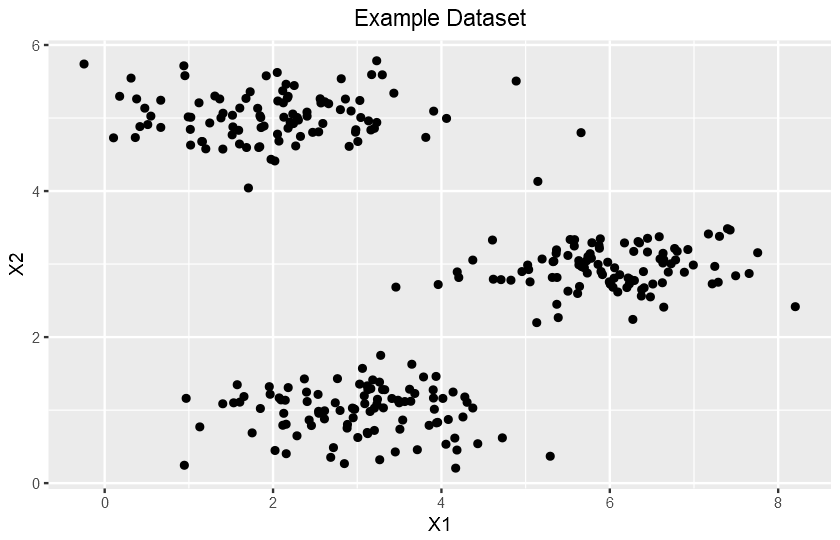

In [3]:
df <- data.frame(X)
ggplot(df) +
  geom_point(aes(x=X1, y=X2)) +
  ggtitle("Example Dataset")

### Implementing $k$-means

The first step is usually initializing the centroids with random values, but we are provided with initial centroids for 

#### Finding Closest Centroids

This step assigns the points in the training data to the clusters of the closest centroids.  After this is accomplished, we'll re-calculate the centroids using the mean value of each point belonging to that cluster in the training data.

For every example $i$, set:

$$c^{(i)} := j\ \text{that minimizes}\ \|x^{(i)} - \mu_j \|^2
\\
c^{(i)}: \text{Index of the centroid that is closest to}\ x^{(i)}\ 
\\
\mu_j: \text{Position (value) of the}\ j\text{'th centroid}$$

In [4]:
find_centroid <- function(X, centroids) {
  # Finds the centroid with the lowest squared error
  # for an individual record
  
  # Calculating the squared error for each centroid
  error <- sweep(centroids, MARGIN=2, X, FUN='-')^2  # sweep subtracts each row by a vector
  error <- rowSums(error)
  
  # Finds the index of the centroid with the lowest error
  cluster <- which.min(error)
  return(cluster)
}


assign_centroid <- function(X, centroids) {
  # Assigns a cluster number to each row of a data set
  cluster <- apply(X, 1, find_centroid, centroids=centroids)
  
  return(cluster)
}


# Creating initial centroids in order to test the function
initialCentroids <- matrix(data=c(3, 3,
                                  6, 2,
                                  8, 5),
                           ncol=2, byrow=TRUE)

# Testing the function
assign_centroid(X, initialCentroids)[1:3]

[1] 1 3 2

Let's run a quick visualization to display our results using the initial centroids:

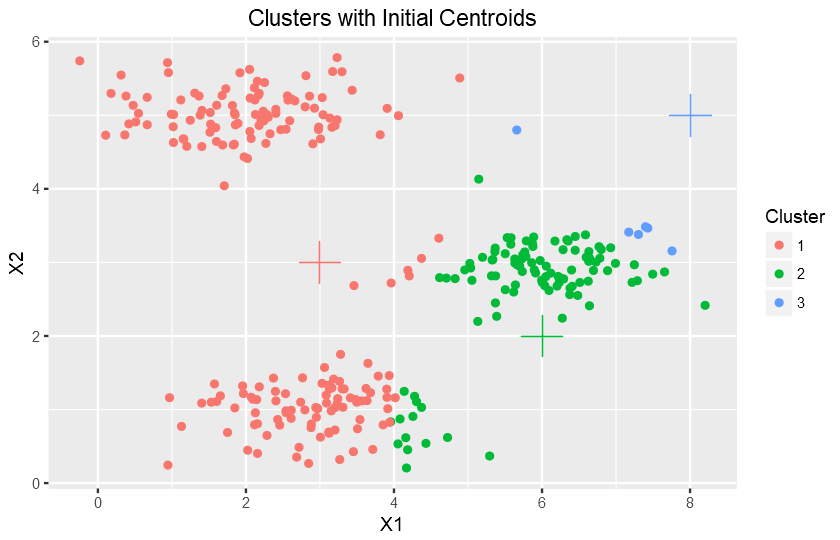

In [5]:
# Adding the clusters to the data frame for plotting
clusters <- assign_centroid(X, initialCentroids)
df$Cluster <- clusters
df$Cluster <- as.factor(df$Cluster)

# Creating a data frame out of the centroids for ggplot
dfCentroids <- data.frame(initialCentroids, Cluster = as.factor(c(1,2,3)))

# Plotting
ggplot(df) +
  geom_point(aes(x=X1, y=X2, color=Cluster)) +
  geom_point(data=dfCentroids, aes(x=X1, y=X2, color=Cluster),
             show.legend=FALSE, size=8, shape=3) + 
  ggtitle("Clusters with Initial Centroids")

#### Computing Centroid 

This is the next step to $k$-means clustering that is used to re-assign centroids.  We do this by merely calculating the mean of the points belonging to each cluster.

For every centroid $k$, set:

$$\mu_k := \frac{1}{|C_k|} \sum_{i \in C_k} x^{(i)}
\\
C_k: \text{Set of examples that are assigned to centroid }k$$

In [6]:
compute_centroids <- function(X, clusters) {
  # Finds the new centroids by calculating the average value
  # of all points contained within each cluster
  
  # Using a lazy approach of groupby in dplyr
  df <- data.frame(X, Cluster=clusters)
  df <- df %>% 
    group_by(Cluster) %>% 
      summarise_each(funs(mean)) %>% 
    ungroup()
  
  # Putting back into a matrix, and removing the cluster column
  centroids <- as.matrix(df)
  centroids <- centroids[, -1]
  
  return(centroids)
}


compute_centroids(X, clusters)

X1,X2
2.428301,3.157924
5.813503,2.633656
7.119387,3.616684


### $k$-means on example dataset

Now that we've built the steps for the algorithm, let's run it on the example dataset.

The code in this section is a little longer in order to produce a graph that shows the steps our algorithm takes for each iteration.

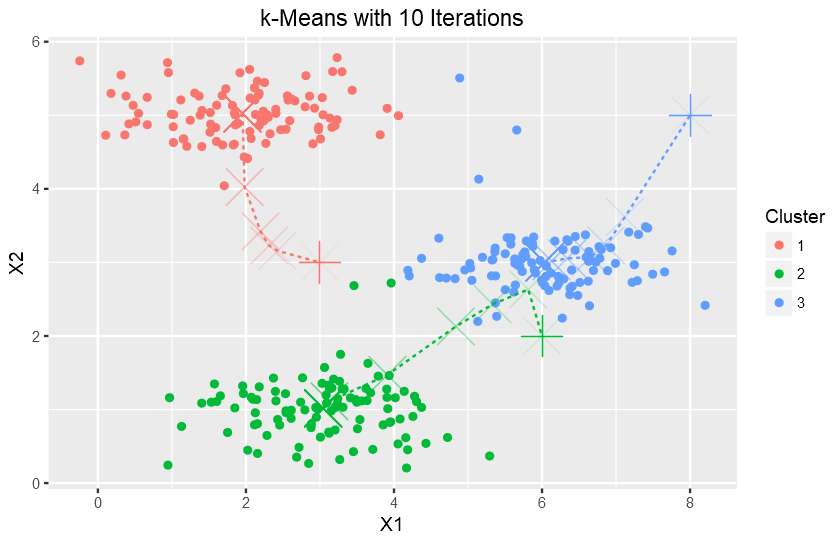

In [7]:
# Setting up names for loop
centroids <- initialCentroids
dfCentroids$k <- 0

# Number of k
iterations <- 10

# Looping through the iterations to find the centroids and assign clusters
for (k in 1:iterations) {
  # Performing k-means
  clusters <- assign_centroid(X, centroids)
  centroids <- compute_centroids(X, clusters)
  
  # Adding centroids to data frame for plotting
  temp.df <- data.frame(centroids, Cluster=c(1, 2, 3), k = k)
  dfCentroids <- rbind(dfCentroids, temp.df)
}

# Assigning the final cluster numbers to the training data
clusters <- assign_centroid(X, centroids)
df$Cluster <- clusters
df$Cluster <- as.factor(df$Cluster)

# Plotting
ggplot(df) +
  # Training points
  geom_point(aes(x=X1, y=X2, color=Cluster)) +
  
  # Original centroids
  geom_point(data=filter(dfCentroids, k == 0),
              aes(x=X1, y=X2, color=Cluster),
             show.legend=FALSE, size=8, shape=3) + 
  
  # Iterative centroids
  geom_point(data=dfCentroids,
              aes(x=X1, y=X2, color=Cluster, alpha=k/10),
             show.legend=FALSE, size=10, shape=4) +
  geom_line(data=dfCentroids,
              aes(x=X1, y=X2, color=Cluster),
            show.legend=FALSE, linetype=2) +
  
  ggtitle("k-Means with 10 Iterations")

### Random Initialization

We were provided with initial centroids for the previous parts of the exercise, but it's prudent to use random starting points (in addition to multiple runs that use different starting points) to avoid falling into a local minima.

### Image Compression with $k$-means

We'll apply $k$-means to an image in order to compress it from a 24-bit color representation (where each pixel is made up of three 8-bit integers ranging from 0 to 255) made up of thousands of colors to just 16 colors.

---

##  *Part II:* Principal Component Analysis

<img width="300px" src="https://upload.wikimedia.org/wikipedia/commons/f/f5/GaussianScatterPCA.svg">

[Principal Components Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) is a dimensionality reduction technique that uses [orthogonal transformation](https://en.wikipedia.org/wiki/Orthogonal_transformation) to reduce linearly correlated variables into linearly uncorrelated variables called principal components.  It is a way to reduce our overall number of features while attempting to preserve as much variance as possible.

In [8]:
# Loading the matrix, assigning X, and removing the matrix from the environment
data <- readMat('ex7/ex7data1.mat')
X <- data$X
rm(data)

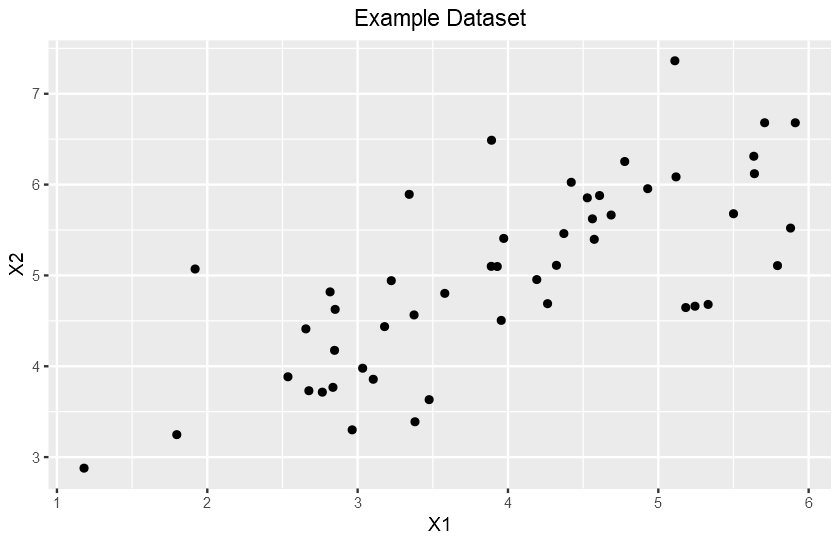

In [9]:
df <- data.frame(X)
ggplot(df) +
  geom_point(aes(x=X1, y=X2)) +
  ggtitle("Example Dataset")

### Implementing PCA

Implementing PCA consists of three steps:
1. Normalize the data
2. Compute the covariance matrix of the data
3. Perform [Singular Value Decomposition (SVD)](https://en.wikipedia.org/wiki/Singular_value_decomposition) to acquire the eigenvectors that correspond to the principal components of variation

#### Normalizing the Data

$$x' = \frac{x - \bar{x}}{\sigma}$$

As always, this ensures that one variable doesn't carry more importance over the others.

#### Computing the Covariance Matrix

$$\sum = \frac{1}{m} X^T X
\\
X: \text{Data matrix with examples in rows}
\\
m: \text{Number of examples}
\\
\sum: n \times n\ \text{matrix (and not a summation operator)}$$

This is a necessary step in order to perform singular value decomposition.

#### Singular Value Decomposition

This provides us with the eigenvectors, which are the principal components.

### Dimensionality Reduction with PCA

After computing the principal components, we'll use them to reduce the feature dimension of the dataset by projecting each example onto a lower dimensional space, $x^{(i)} \rightarrow z^{(i)}$

We'll use the eigenvectors returned by PCA and project the example dataset into a 1-dimensional space

#### Projecting Data onto Principal Components

Given a dataset, $X$, the principal components, $U$, and the desired number of dimension to reduce to, $k$, we will project each example in $X$ onto the top $k$ components in $U$.  

Note: the top $K$ components in $U$ are given by the first $k$ columns of $U$.

#### Reconstructing an Approximation of the Data

After projecting the data onto the lower dimensional space, we can approximately recover the data by projecting them back onto the original high dimensional space.

#### Visualizing the Projections

### Face Image Dataset

This dataset contains 5,000 images of faces made up of $32 \times 32$ greyscale pixels

In [10]:
# Loading the matrix, assigning X, and removing the matrix from the environment
data <- readMat('ex7/ex7faces.mat')
X <- data$X
rm(data)

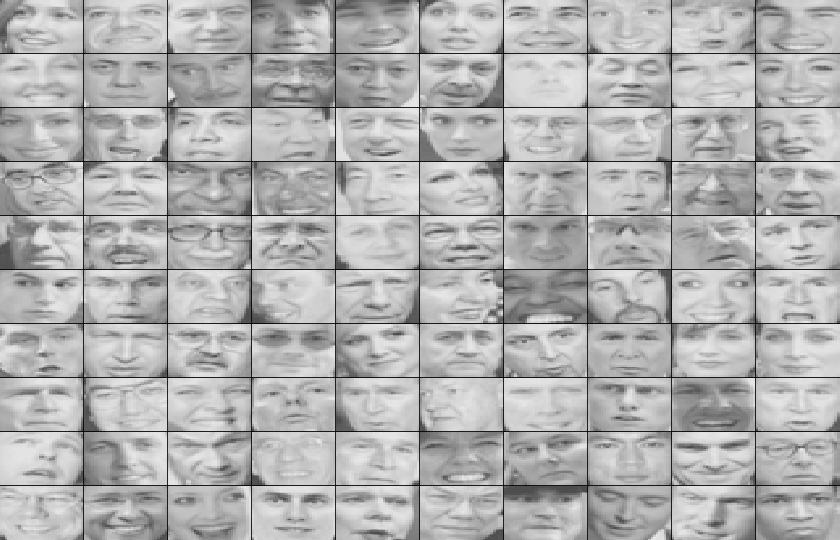

In [11]:
# Randomly selecting 100 digits to plot
rowsToPlot <- X[sample(nrow(X),size=100,replace=FALSE),]

row_to_matrix <- function(row) {
  # Formats a row from the matrix X into a matrix suitable for plotting with image()
  digit <- matrix(row, nrow=32, ncol=32)  # Puts row into a 20x20 matrix
  digit <- t(apply(digit, 2, rev))  # Rotates matrix into correct position for image()
  return(digit)
}

plot_faces <- function(faces) {
  # Plots a grid of the supplied faces
  
  # Calculating parameters for the plot
  m <- dim(faces)[1]  # Number of faces to plot
  columns <- floor(sqrt(m))  # Number of columns
  rows <- ceiling(sqrt(m))  # Number of rows

  # Parameters for the overall plot
  par(mfrow=c(rows, columns),  # Rows, columns
      mar=c(0.0, 0.0, 0.0, 0.0))  # Margins between plots

  # Looping through the faces and plotting them
  for (i in 1:m) {
  image(row_to_matrix(faces[i, ]),  # Formats faces
        col=grey.colors(255),  # Colors to gray scale
        xaxt='n', yaxt='n')  # Remoxes axis labels and tick marks
  }
}

plot_faces(rowsToPlot)

#### PCA on Faces

As a reminder, here are the steps we have to perform:

1. Normalize the dataset
2. Calculate the covariance matrix
3. Perform SVD to extract the principal components

Since we already built the functions for these steps, I'll just call our pca function.

#### Dimensionality Reduction